# benchmarking on omnipath


In [1]:
from bengrn import BenGRN
import scanpy as sc

from anndata.utils import make_index_unique
from grnndata import utils as grnutils

import pandas as pd

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

In [2]:
import shutil
import os

from geneformer import EmbExtractor
from geneformer import TranscriptomeTokenizer
from grnndata import GRNAnnData

from geneformer import TOKEN_DICTIONARY_FILE
import pickle

with open(TOKEN_DICTIONARY_FILE, "rb") as f:
    gene_mapping_dict = pickle.load(f)

def compute_geneformer_network(adata, model="../../Geneformer/gf-12L-30M-i2048/", model_type="Pretrained", forward_batch_size=4, max_ncells=1000, ):
    adata = adata[:, adata.var.index.isin([u for u in gene_mapping_dict.keys() if u in adata.var.index])]
    adata.var['ensembl_id'] = adata.var.index
    adata.obs['n_counts'] = adata.X.sum(1)
    # Create the geneformer folder if it doesn't exist
    geneformer_folder = "/tmp/geneformer"
    if not os.path.exists(geneformer_folder):
        os.makedirs(geneformer_folder)
    adata.write_h5ad("/tmp/geneformer/test.h5ad")

    genelist = [gene_mapping_dict[u] for u in adata.var.index]

    tokenized_data_path = "/tmp/geneformer/tokenized_data.dataset/"
    if os.path.exists(tokenized_data_path):
        shutil.rmtree(tokenized_data_path)
    tk = TranscriptomeTokenizer(nproc=16, model_input_size=2048)
    tk.tokenize_data("/tmp/geneformer/", 
                    "/tmp/geneformer/",
                    "tokenized_data", 
                    file_format="h5ad")
    embex = EmbExtractor(model_type=model_type, #CellClassifier
                     max_ncells=max_ncells,
                     emb_mode="cell",
                     forward_batch_size=forward_batch_size,
                     nproc=16,
                     genelist=genelist)
    embs, avg_attentions = embex.extract_embs(model, #../../../Geneformer/fine_tuned_models/gf-6L-30M-i2048_CellClassifier_cardiomyopathies_220224/
                          "/tmp/geneformer/tokenized_data.dataset/",
                          "/tmp/geneformer",
                          "geneformertest",
                          get_avg_attentions=True,
                          )
    return GRNAnnData(adata.copy(), grn=avg_attentions.to("cpu").numpy())

In [3]:
genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']
#genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']
NUM_GENES = 5000
MAXCELLS = 1024

In [4]:
CELLTYPES = [
"fibroblast",
"endothelial cell",
"myofibroblast cell",
"glial cell",
"pericyte",
"lymphocyte",
"stromal cell",
]

In [5]:
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/Gz5G2ETTEuuRDgwm7brA.h5ad')
#adata = sc.read_h5ad('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint/.lamindb/Gz5G2ETTEuuRDgwm7brA.h5ad')
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
#adata = adata[:, adata.var.index.isin(genes)]
adata

AnnData object with n_obs × n_vars = 23061 × 70263
    obs: 'biosample_id', 'n_genes', 'n_counts', 'Type', 'donor_id', 'Layer', 'Celltype', 'organism_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'suspension_type', 'is_primary_data', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'age group', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'cell_culture'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'uid', 'symbo

/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/tmp/ipykernel_162359/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad
/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


Creating dataset.


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is N

  0%|          | 0/250 [00:00<?, ?it/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


base enrichment
Top central genes: []


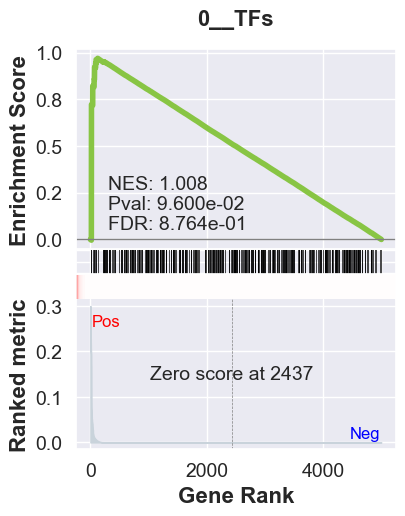

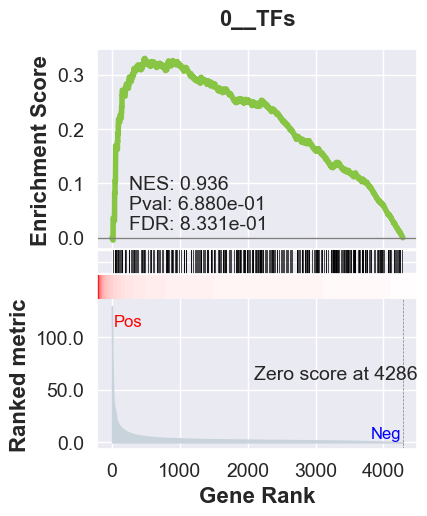

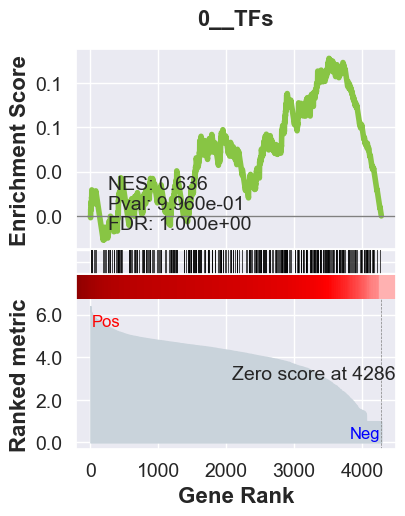

_________________________________________
TF specific enrichment
found some significant results for  7.142857142857143 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3294 genes
intersection pct: 0.6588
precision:  0.0013320223641194594 
recall:  0.7164886354509677 
random precision: 0.0011478599616378212


 99%|█████████▉| 127/128 [00:02<00:00, 62.43it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 60.67it/s]


Average Precision (AP):  0.0015248386681275077
Area Under Precision-Recall Curve (AUPRC):  0.001505131156608279
EPR: 2.951851922157705


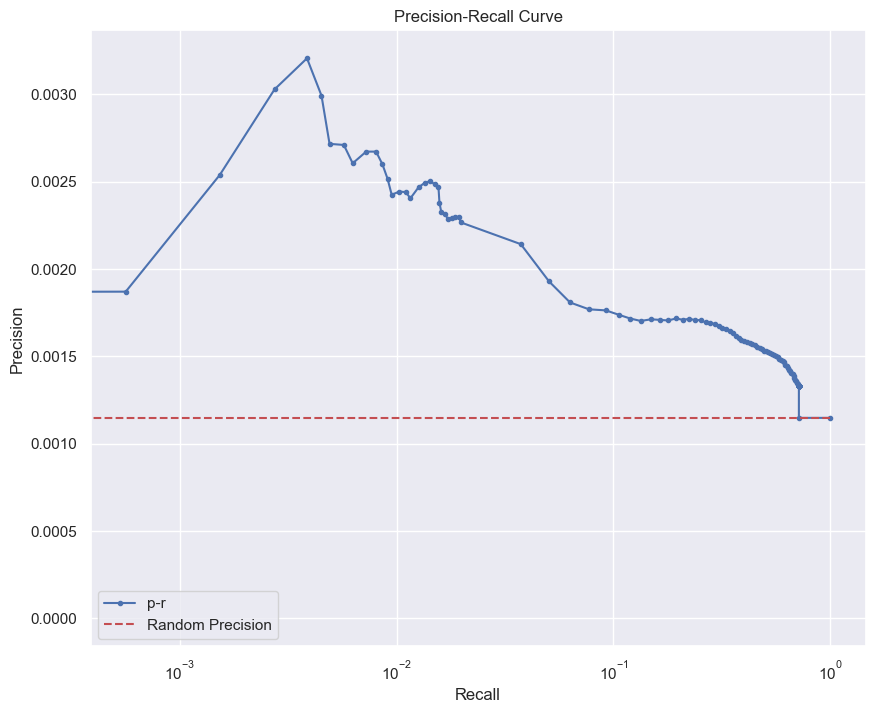

base enrichment
Top central genes: []


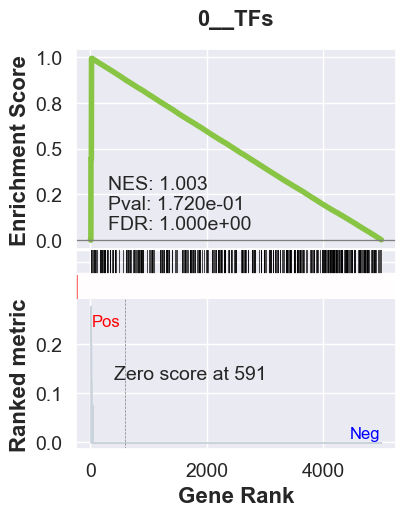

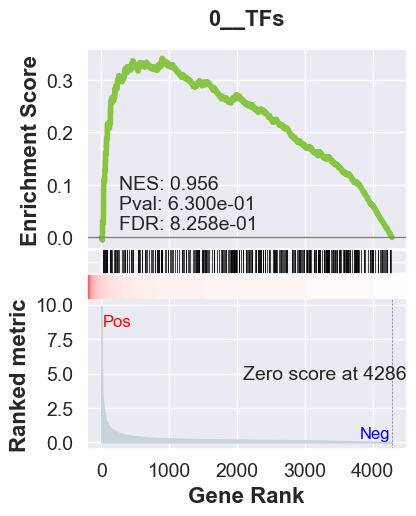

_________________________________________
TF specific enrichment
found some significant results for  7.142857142857143 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3294 genes
intersection pct: 0.6588
precision:  0.008549099950757184 
recall:  0.45177094209300456 
random precision: 0.0011478599616378212


 99%|█████████▉| 127/128 [00:02<00:00, 60.37it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 59.70it/s]


Average Precision (AP):  0.006042273344265614
Area Under Precision-Recall Curve (AUPRC):  0.005331659293674825
EPR: 9.704936419133093


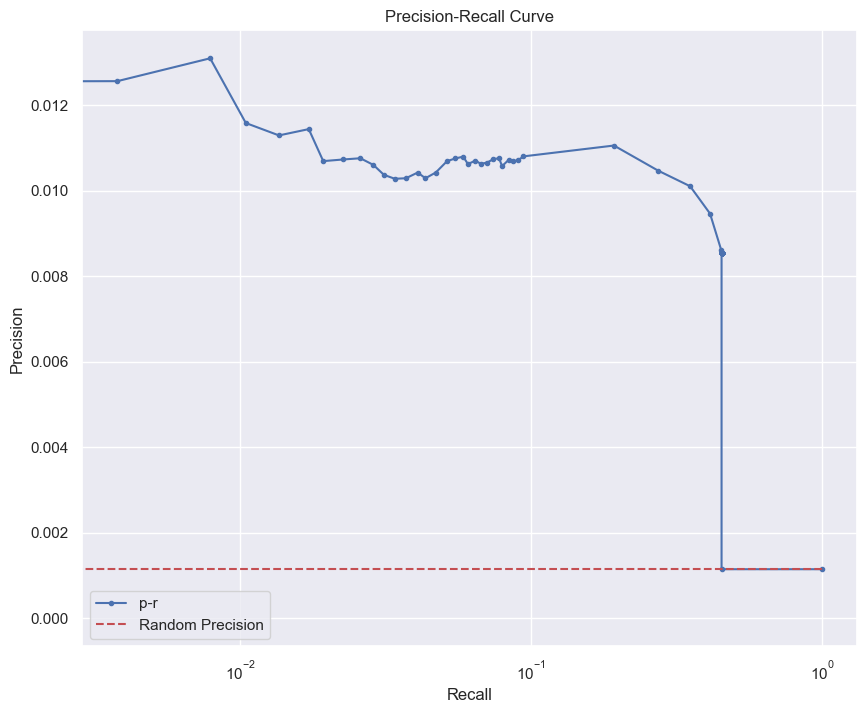

/tmp/ipykernel_162359/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment
Top central genes: []


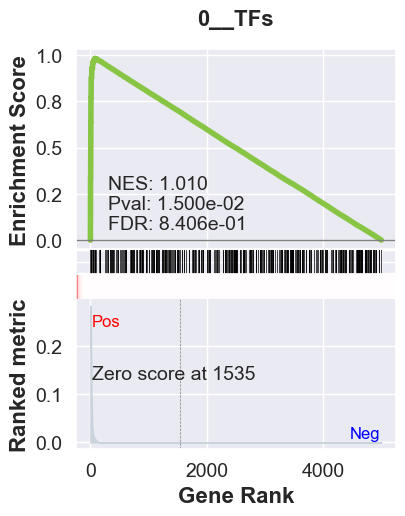

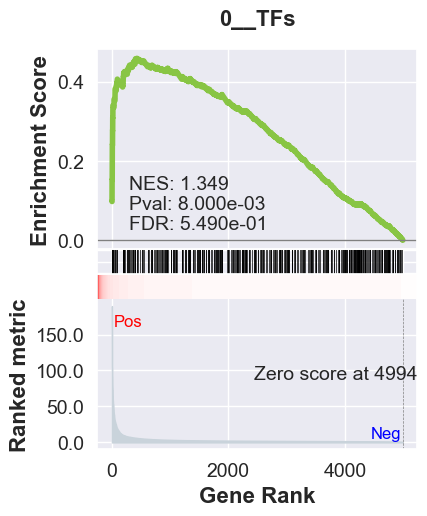

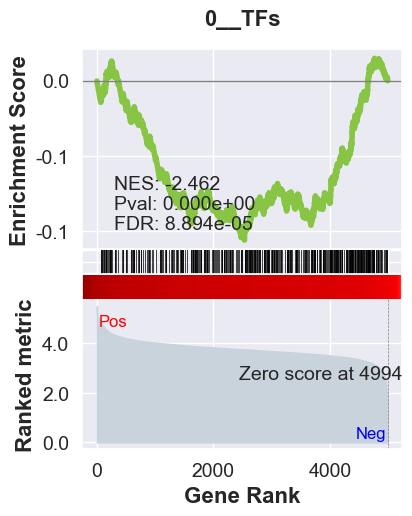

_________________________________________
TF specific enrichment
found some significant results for  4.6875 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3648 genes
intersection pct: 0.7296
precision:  0.0017335390449855854 
recall:  0.9860726681604499 
random precision: 0.0017108059255624667


 98%|█████████▊| 125/128 [00:02<00:00, 45.11it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 43.73it/s]


Average Precision (AP):  0.0017854245130055919
Area Under Precision-Recall Curve (AUPRC):  0.0017846187843201765
EPR: 0.6412313753503173


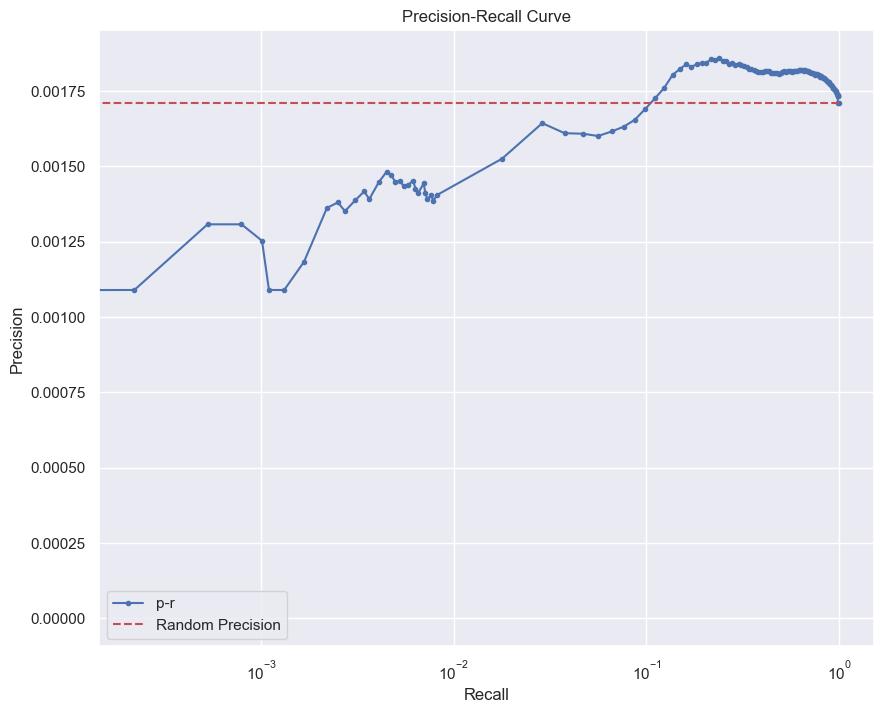

base enrichment
Top central genes: []


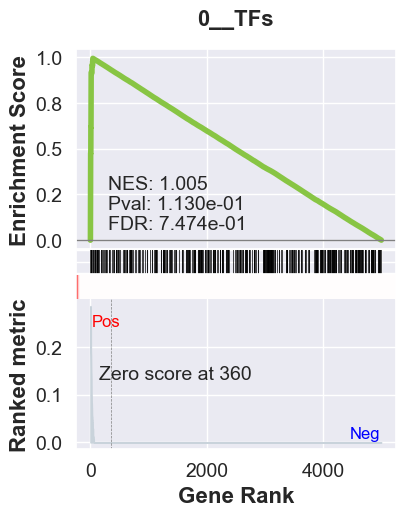

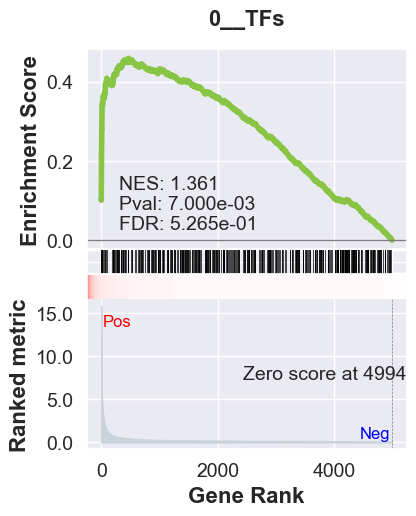

_________________________________________
TF specific enrichment
found some significant results for  6.25 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3648 genes
intersection pct: 0.7296
precision:  0.00722617662183009 
recall:  0.41057071306181625 
random precision: 0.0017108059255624667


 97%|█████████▋| 124/128 [00:02<00:00, 47.25it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 46.82it/s]


Average Precision (AP):  0.004982154966310956
Area Under Precision-Recall Curve (AUPRC):  0.00428455949544888
EPR: 4.495709798364049


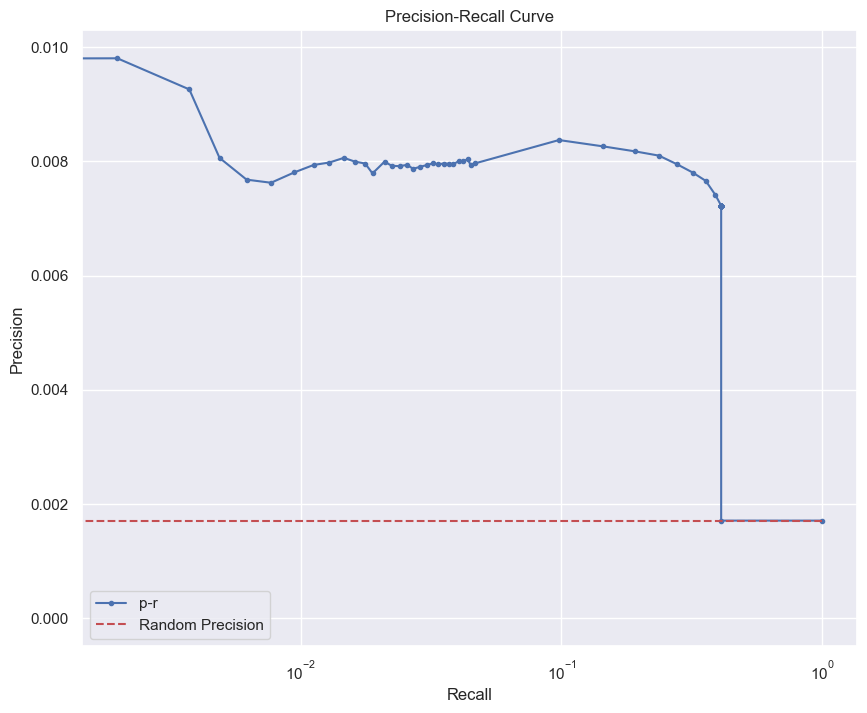

/tmp/ipykernel_162359/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment
Top central genes: []


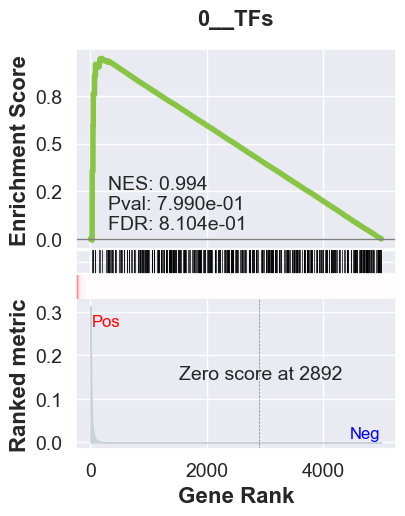

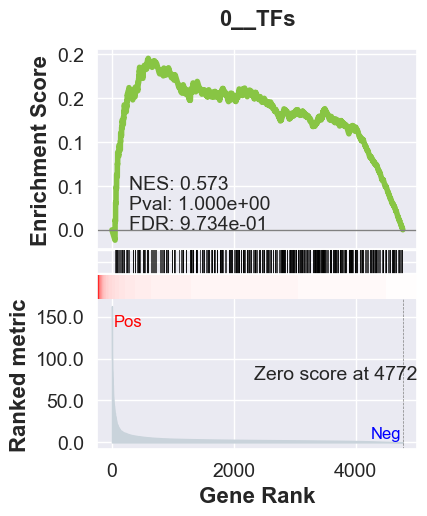

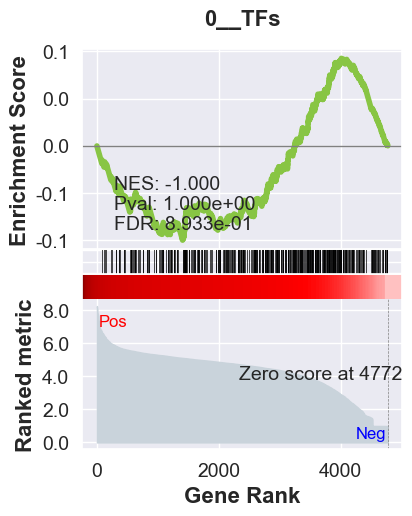

_________________________________________
TF specific enrichment
found some significant results for  9.090909090909092 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3364 genes
intersection pct: 0.6728
precision:  0.0006324045494534218 
recall:  0.7621564482029598 
random precision: 0.0005853374644616539


 98%|█████████▊| 126/128 [00:02<00:00, 62.07it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 61.85it/s]


Average Precision (AP):  0.000694918785546511
Area Under Precision-Recall Curve (AUPRC):  0.0006899802240140766
EPR: 2.0665030578583203


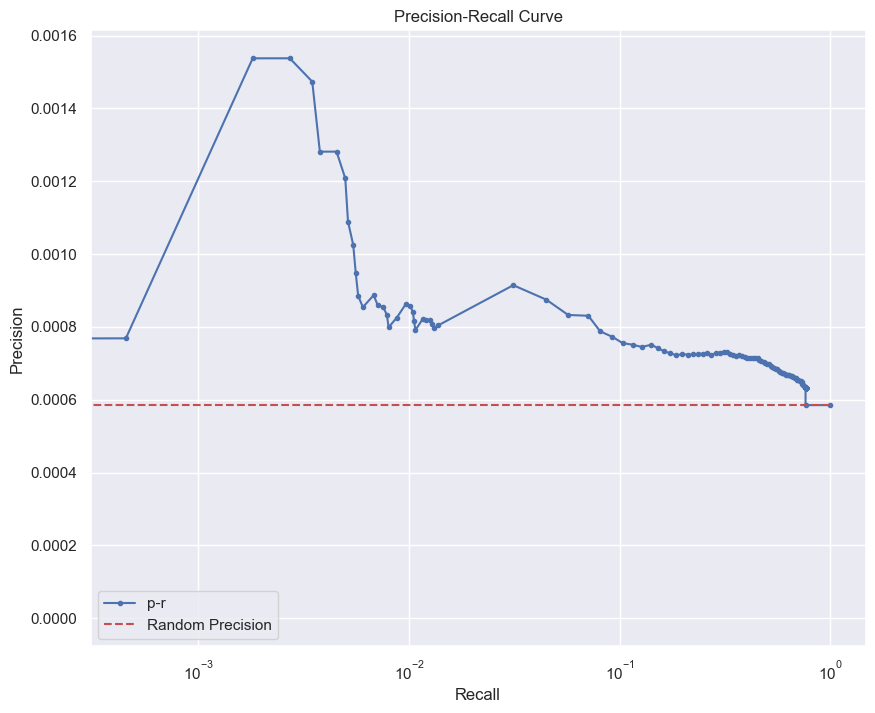

base enrichment
Top central genes: []


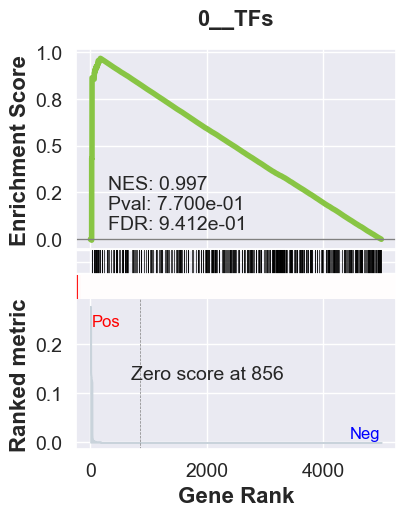

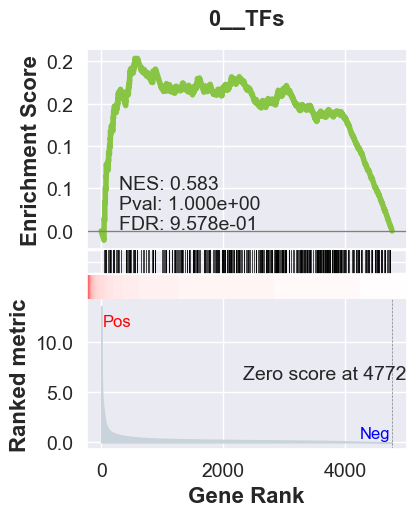

_________________________________________
TF specific enrichment
found some significant results for  9.090909090909092 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3364 genes
intersection pct: 0.6728
precision:  0.0015700405065574789 
recall:  0.1945031712473573 
random precision: 0.0005853374644616539


 98%|█████████▊| 126/128 [00:02<00:00, 59.28it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 59.10it/s]


Average Precision (AP):  0.0009669219462554772
Area Under Precision-Recall Curve (AUPRC):  0.0008136483706046263
EPR: 4.663727928047572


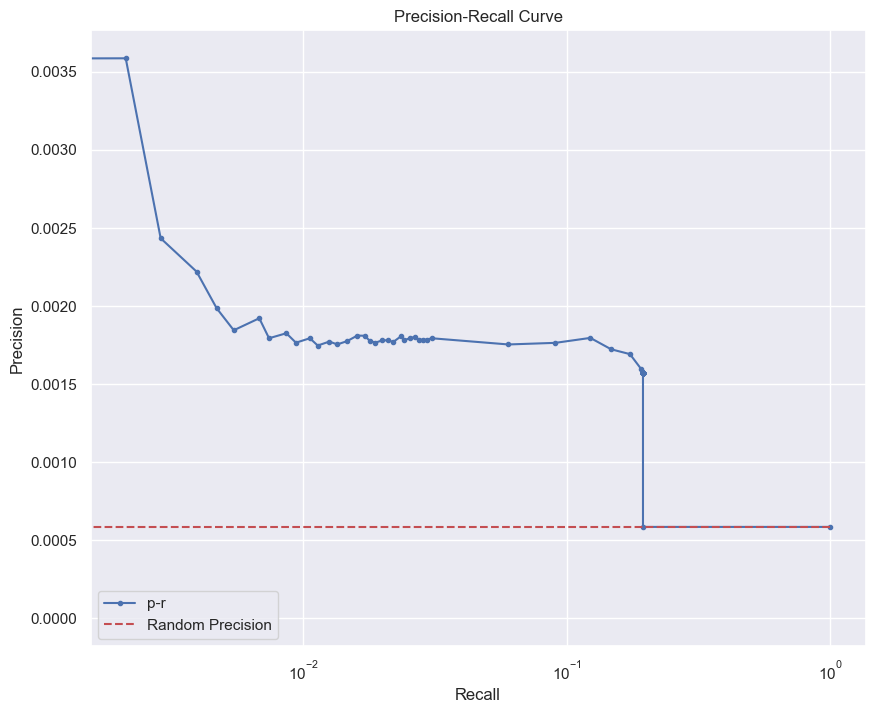

/tmp/ipykernel_162359/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad
/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment
Top central genes: []


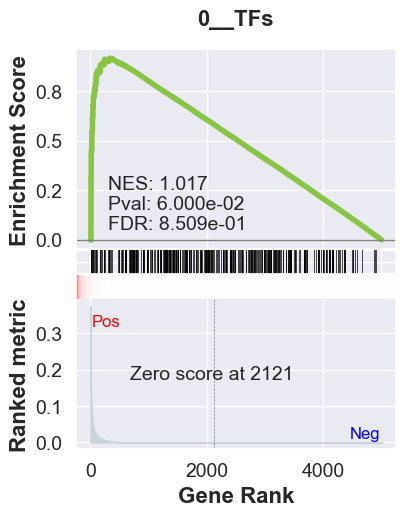

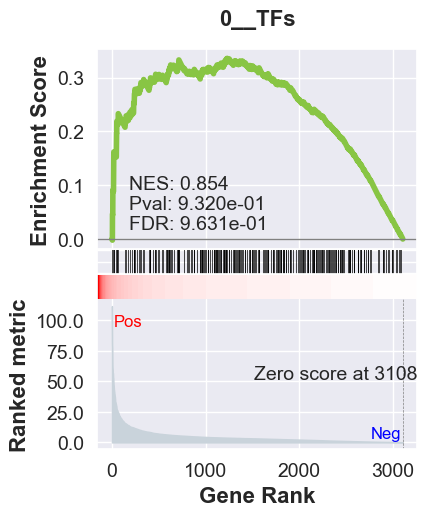

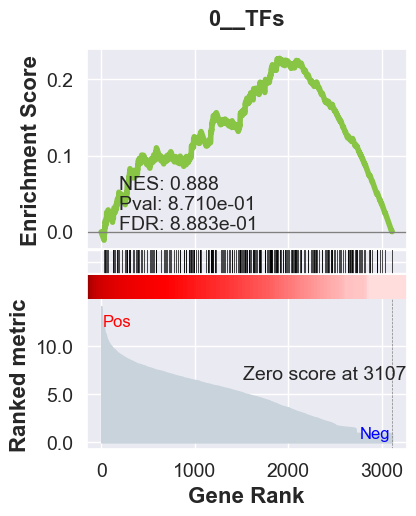

_________________________________________
TF specific enrichment
found some significant results for  6.25 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2633 genes
intersection pct: 0.5266
precision:  0.001017247661848658 
recall:  0.46754070628039757 
random precision: 0.000680837218141454


 93%|█████████▎| 119/128 [00:01<00:00, 99.36it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 100.06it/s]


Average Precision (AP):  0.0009392696815818364
Area Under Precision-Recall Curve (AUPRC):  0.000861101271696922
EPR: 1.2427703143808964


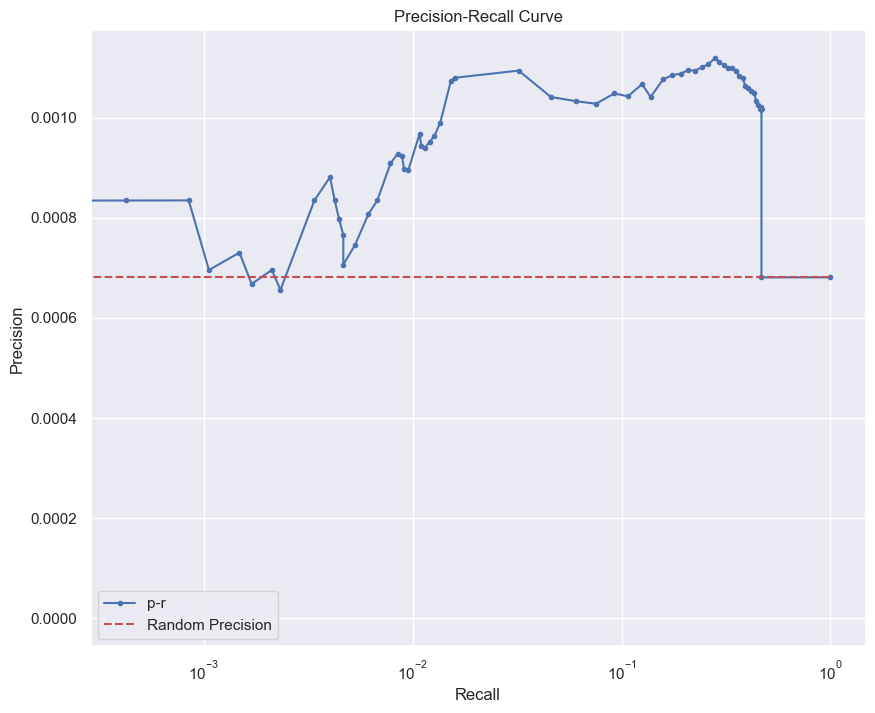

base enrichment
Top central genes: []


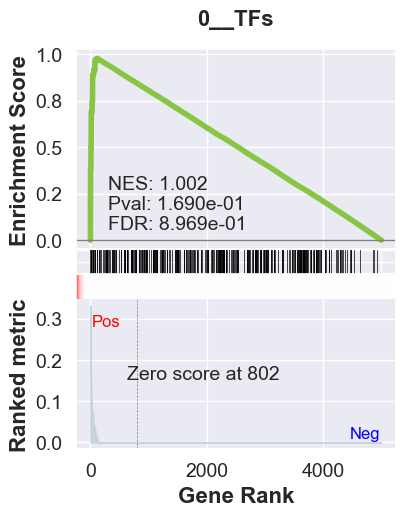

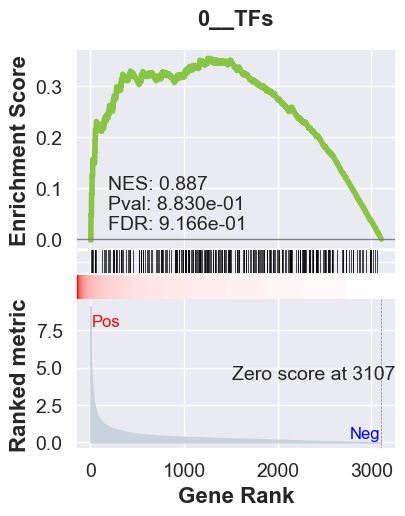

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2633 genes
intersection pct: 0.5266
precision:  0.0038499425734822837 
recall:  0.189257771198985 
random precision: 0.000680837218141454


 94%|█████████▍| 120/128 [00:01<00:00, 101.92it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 101.28it/s]


Average Precision (AP):  0.0017886254201294727
Area Under Precision-Recall Curve (AUPRC):  0.0013284851864203224
EPR: 5.310967905877707


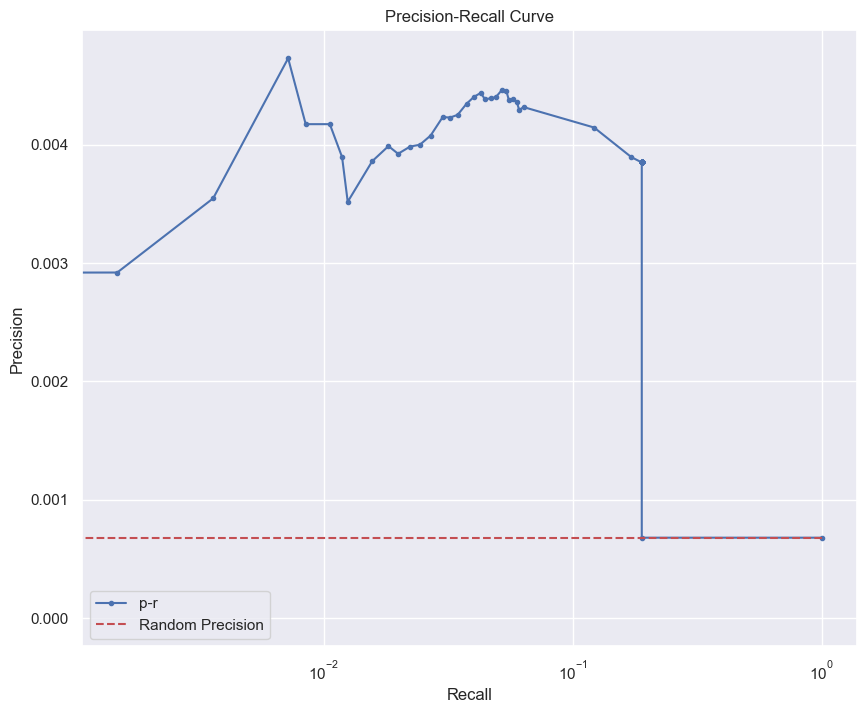

/tmp/ipykernel_162359/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad
/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/193 [00:00<?, ?it/s]

base enrichment
Top central genes: []


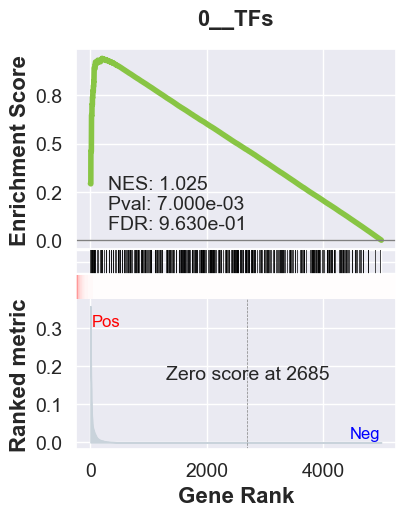

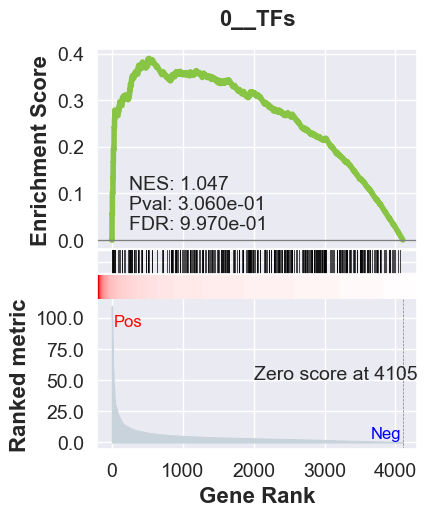

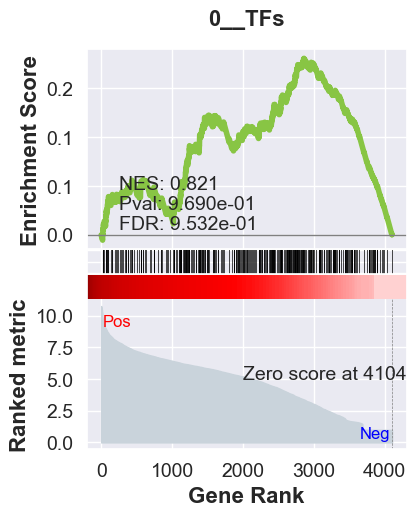

_________________________________________
TF specific enrichment
found some significant results for  20.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3084 genes
intersection pct: 0.6168
precision:  0.0011891614789700322 
recall:  0.6191632630533171 
random precision: 0.0009441861832177707


 98%|█████████▊| 126/128 [00:01<00:00, 68.26it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 67.63it/s]


Average Precision (AP):  0.0011705879705751147
Area Under Precision-Recall Curve (AUPRC):  0.0011470873265148245
EPR: 0.7010810291552468


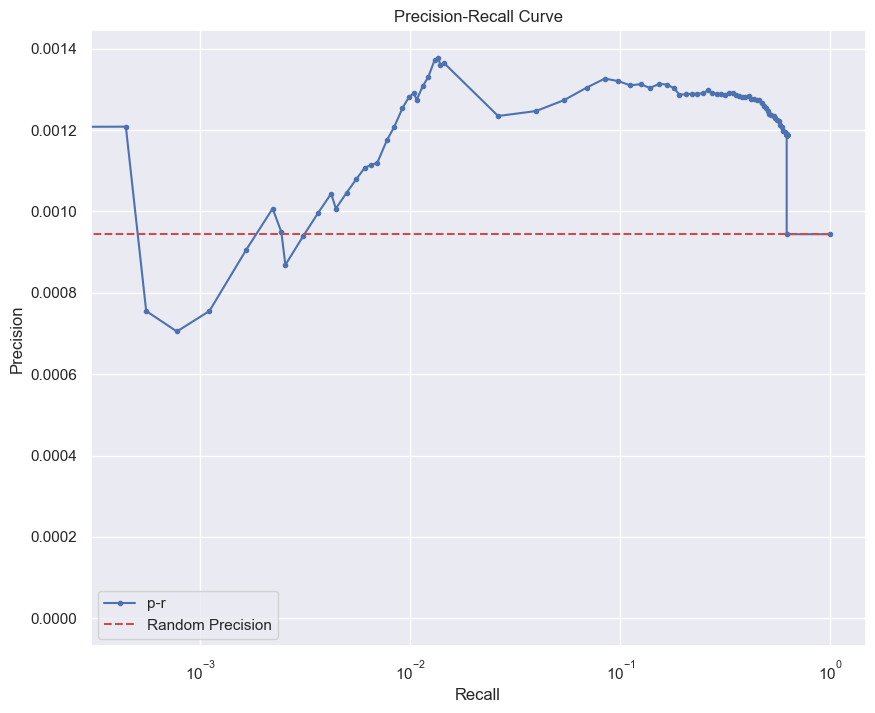

base enrichment
Top central genes: []


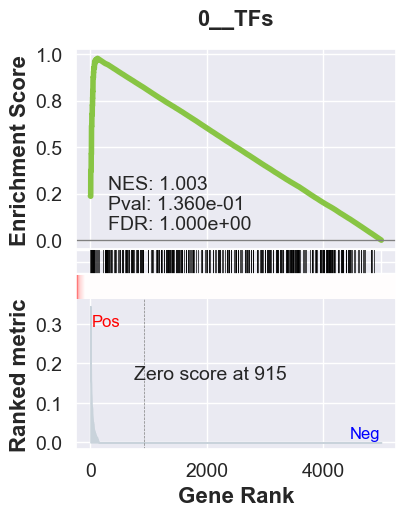

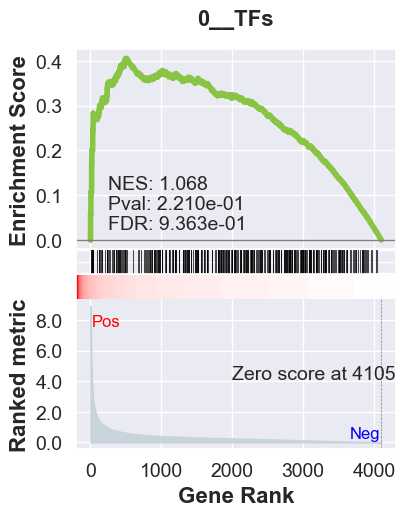

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3084 genes
intersection pct: 0.6168
precision:  0.0056923249745087535 
recall:  0.29087095705927807 
random precision: 0.0009441861832177707


 99%|█████████▉| 127/128 [00:01<00:00, 68.25it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 66.60it/s]


Average Precision (AP):  0.003283703362648712
Area Under Precision-Recall Curve (AUPRC):  0.0025921407398824896
EPR: 7.695064629106381


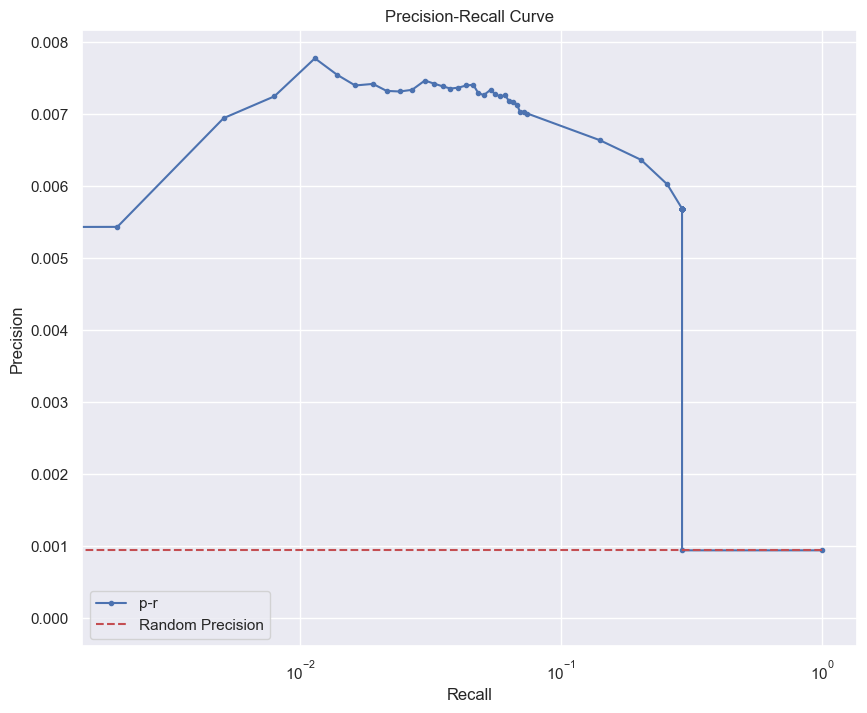

/tmp/ipykernel_162359/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/92 [00:00<?, ?it/s]

base enrichment
Top central genes: []


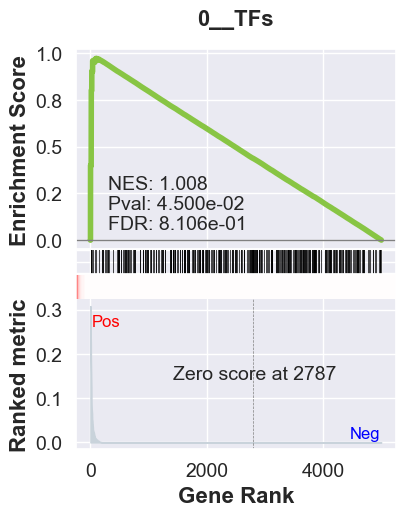

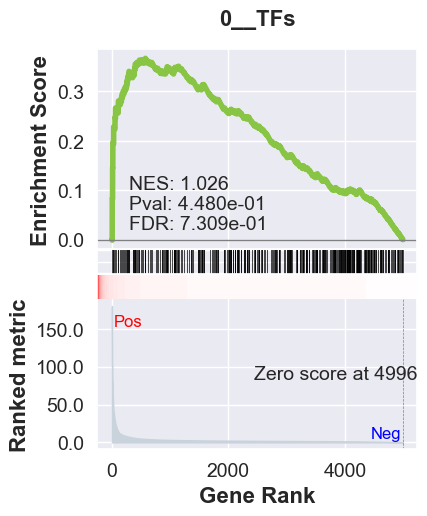

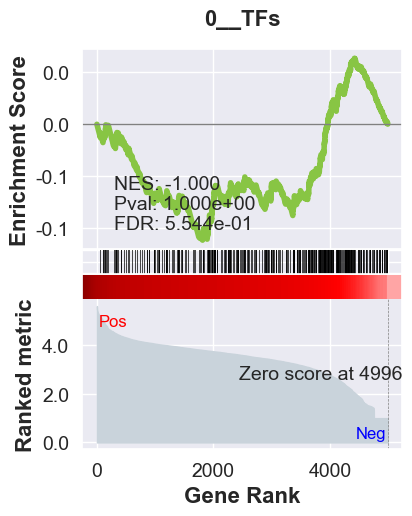

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3483 genes
intersection pct: 0.6966
precision:  0.0011284196789032742 
recall:  0.8168097070139094 
random precision: 0.001114463737299228


 98%|█████████▊| 126/128 [00:02<00:00, 56.49it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 55.12it/s]


Average Precision (AP):  0.0011661392625251618
Area Under Precision-Recall Curve (AUPRC):  0.0011678294487545164
EPR: 1.4620263793717891


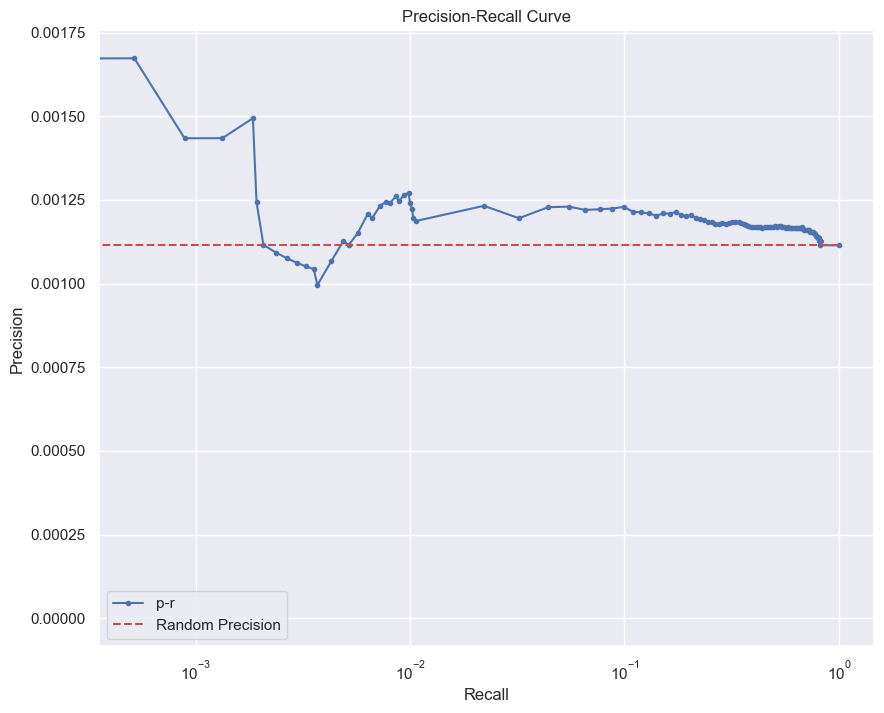

base enrichment
Top central genes: []


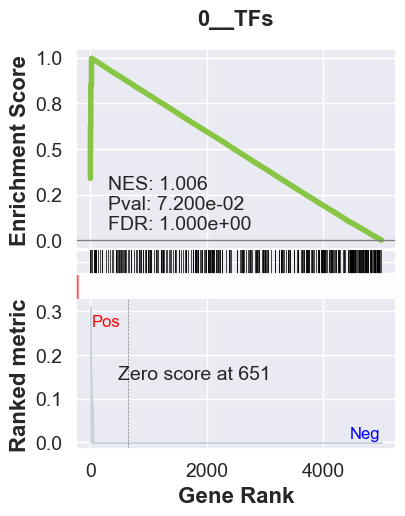

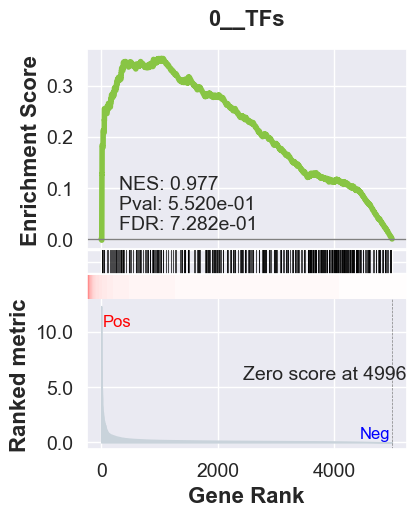

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3483 genes
intersection pct: 0.6966
precision:  0.006587919350439544 
recall:  0.394939331163066 
random precision: 0.001114463737299228


 98%|█████████▊| 126/128 [00:02<00:00, 55.74it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 55.63it/s]


Average Precision (AP):  0.004091445440567264
Area Under Precision-Recall Curve (AUPRC):  0.003528819043063518
EPR: 5.769825281970051


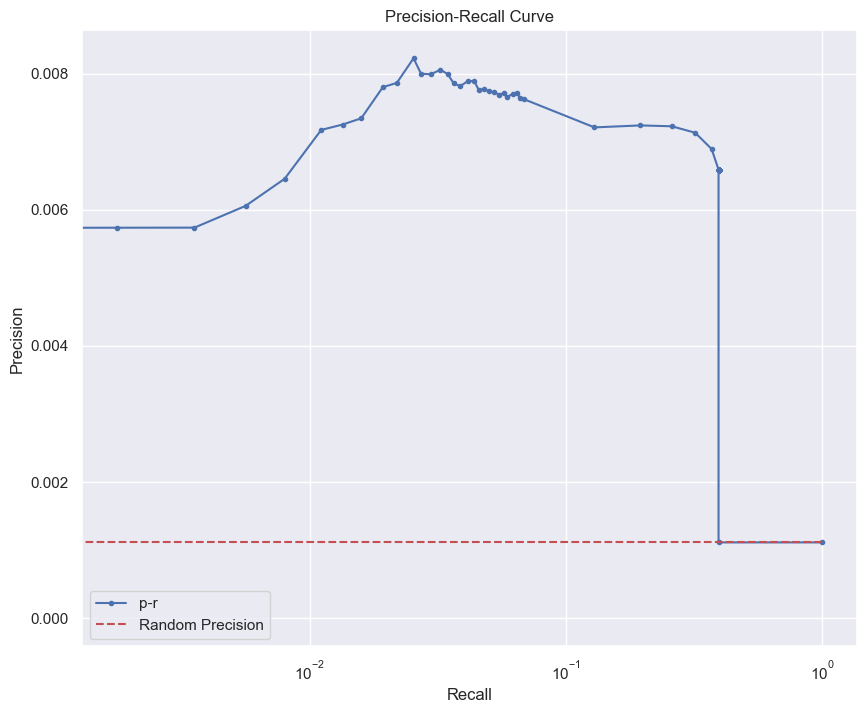

/tmp/ipykernel_162359/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad
/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/65 [00:00<?, ?it/s]

base enrichment
Top central genes: []


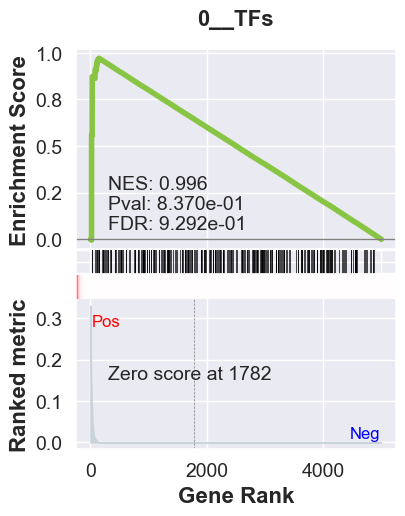

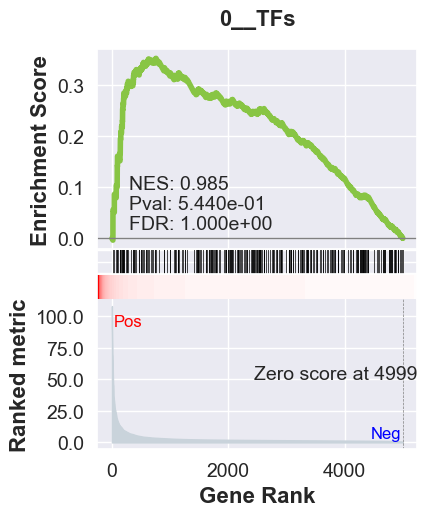

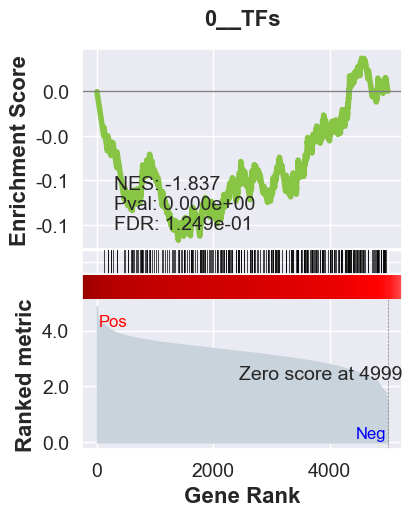

_________________________________________
TF specific enrichment
found some significant results for  11.764705882352942 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3466 genes
intersection pct: 0.6932
precision:  0.0011893221502390383 
recall:  0.9597154678086666 
random precision: 0.0011471570040525608


 98%|█████████▊| 126/128 [00:02<00:00, 57.06it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 56.78it/s]


Average Precision (AP):  0.0012066944542163441
Area Under Precision-Recall Curve (AUPRC):  0.001205494856472412
EPR: 0.5688992557753776


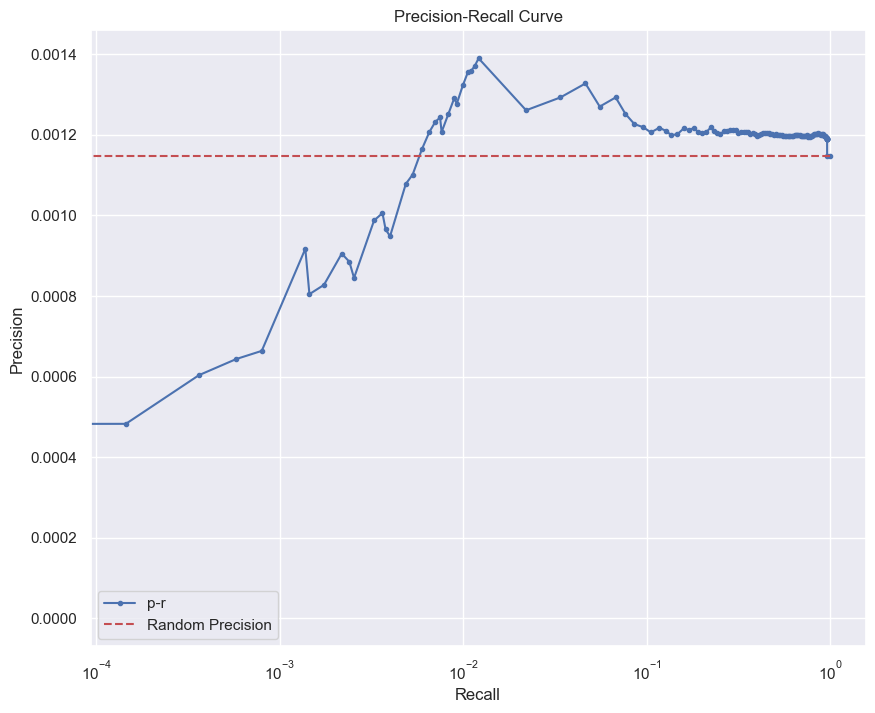

base enrichment
Top central genes: []


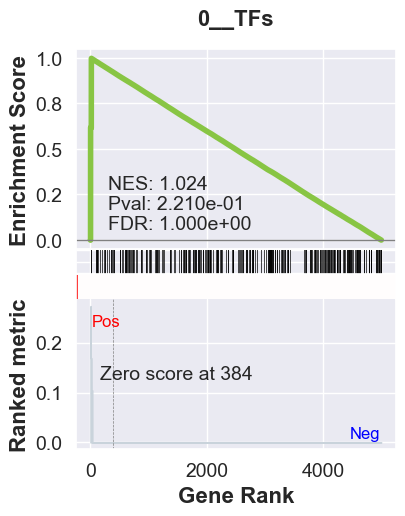

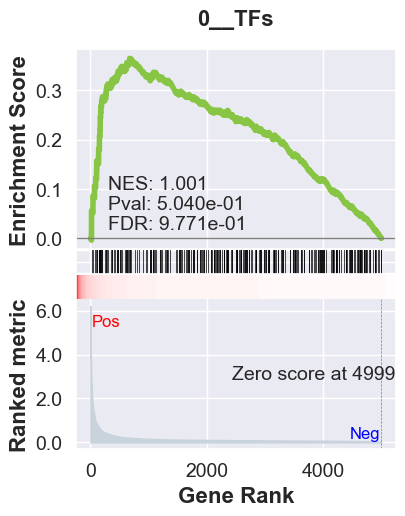

_________________________________________
TF specific enrichment
found some significant results for  2.9411764705882355 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3466 genes
intersection pct: 0.6932
precision:  0.0064150819456760926 
recall:  0.35443129854104666 
random precision: 0.0011471570040525608


 98%|█████████▊| 126/128 [00:02<00:00, 56.67it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 54.64it/s]


Average Precision (AP):  0.0037364209106123623
Area Under Precision-Recall Curve (AUPRC):  0.0032013908869850454
EPR: 6.1457270974449765


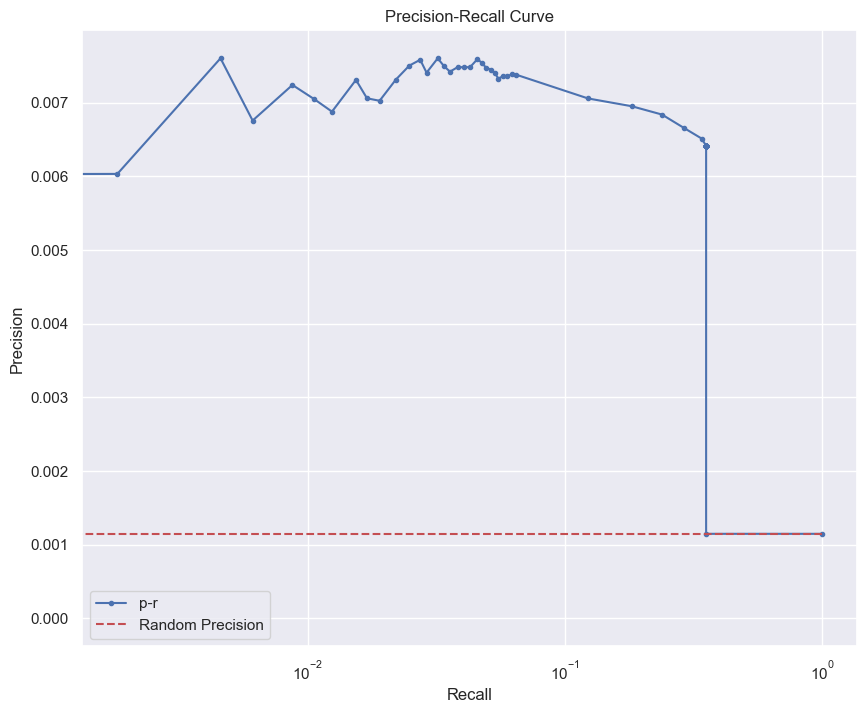

In [6]:
adata.var['ensembl_id'] = adata.var.index
adata = adata[adata.X.sum(1) > 500, adata.var.index.isin(gene_mapping_dict.keys())]
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
metrics = {}
shapes = []
for celltype in CELLTYPES:
    to_use = adata.uns["rank_genes_groups"]["names"][celltype][
        : NUM_GENES
    ].tolist()
    subadata = adata[adata.obs.cell_type == celltype][:MAXCELLS, adata.var.index.isin(to_use)]
    grn = compute_geneformer_network(
        subadata)
    grn.var.index = make_index_unique(
        grn.var['symbol'].astype(str))
    metrics['geneformer_'+celltype] = BenGRN(grn,
                                            do_auc=True, doplot=True).scprint_benchmark()
    grn.varp['GRN'][~grn.var.isTF, :] = 0
    grn.var.index = make_index_unique(
        grn.var['symbol'].astype(str))
    metrics['geneformer_tf_'+celltype] = BenGRN(grn,
                                         do_auc=True, doplot=True).scprint_benchmark()
    shapes.append(grn.shape[1])

In [7]:
metrics

{'geneformer_fibroblast': {'TF_enr': False,
  'enriched_terms_Targets': ['celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Pancreatic stellate cells',
   'celltype.gmt__Stromal cells',
   'celltype.gmt__Odontoblasts',
   'celltype.gmt__Fibroblasts',
   'celltype.gmt__Mesangial cells',
   'celltype.gmt__Mesenchymal stem cells',
   'celltype.gmt__Smooth muscle cells',
   'celltype.gmt__Myofibroblasts',
   'celltype.gmt__Endothelial',
   'celltype.gmt__Microfold cells',
   'celltype.gmt__Pulmonary alveolar type I cells'],
  'significant_enriched_TFtargets': 7.142857142857143,
  'precision': 0.0013320223641194594,
  'recall': 0.7164886354509677,
  'rand_precision': 0.0011478599616378212,
  'auprc': 0.001505131156608279,
  'ap': 0.0015248386681275077,
  'epr': 2.951851922157705},
 'geneformer_TF_fibroblast': {'TF_enr': False,
  'significant_enriched_TFtargets': 7.142857142857143,
  'precision': 0.008549099950757184,
  'recall': 0.45177094209300456,
  'rand_precision': 0.001147859961

In [8]:
shapes

[5000, 5000, 5000, 5000, 5000, 5000, 5000]

In [9]:
True
False
True
False
True
False
True
False
False
False
False
False
True
False

False

In [10]:
import pandas as pd

In [12]:
res = []
for k, v in metrics.items():
    res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,fibroblast,2.951852,0.001505,0.001148,7.142857,False,False
1,fibroblast,9.704936,0.005332,0.001148,7.142857,False,False
2,endothelial cell,0.641231,0.001785,0.001711,4.687500,True,False
3,endothelial cell,4.495710,0.004285,0.001711,6.250000,False,False
4,myofibroblast cell,2.066503,0.000690,0.000585,9.090909,False,False
5,myofibroblast cell,4.663728,0.000814,0.000585,9.090909,False,False
6,glial cell,1.242770,0.000861,0.000681,6.250000,False,False
7,glial cell,5.310968,0.001328,0.000681,0.000000,False,False
8,pericyte,0.701081,0.001147,0.000944,20.000000,False,False
9,pericyte,7.695065,0.002592,0.000944,0.000000,False,False
